In [322]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


In [323]:
data_1 = pd.read_csv('data/Drugs_2018.csv')

# extract the drug feature
data_1 = data_1[['ST_CASE', 'DRUGRES']]
#for the DRUGRES column, make 0 and 1 as 0, and others as 1
data_1['DRUGRES'] = data_1['DRUGRES'].apply(lambda x: 0 if x in [0,1]  else 1)
print(data_1.head())

   ST_CASE  DRUGRES
0    10001        0
1    10002        0
2    10002        0
3    10003        1
4    10003        1


In [324]:
def preprocess_data(accident_file, drugs_file):

    data = pd.read_csv(accident_file, encoding='latin1')
    data = data[[ 'ST_CASE', 'LGT_CONDNAME', 'WEATHERNAME', 'RUR_URBNAME' ,'DRUNK_DR', 'PERSONS', 'FATALS']]
    data_1 = pd.read_csv(drugs_file)
    # extract the drug feature
    data_1 = data_1[['ST_CASE', 'DRUGRES']]
    data_1['DRUGRES'] = data_1['DRUGRES'].apply(lambda x: 0 if x in [0, 1] else 1)

     # merge the two datasets
    data = pd.merge(data, data_1, on='ST_CASE', how='left')
    
    columns = list(data.columns)
    # get the new columns
    new_columns = [col for col in data_1.columns if col not in data.columns[:-len(data_1.columns)]]
    # move the new columns to the second last position
    for col in new_columns:
        columns.remove(col)
        columns.insert(-2, col)
    # re-order the columns
    data = data[columns]
    
    return data

data_2018 = preprocess_data('data/accident_2018.csv', 'data/Drugs_2018.csv')
data_2019 = preprocess_data('data/accident_2019.csv', 'data/Drugs_2019.csv')
data_2020 = preprocess_data('data/accident_2020.csv', 'data/Drugs_2020.csv')


# merge all the data
all_data = pd.concat([data_2018, data_2019, data_2020,], ignore_index=True)

print(all_data.shape)
print(all_data.head())

/var/folders/t9/plt56vgx1nx_6xff98fhl2dc0000gn/T/ipykernel_10212/616569146.py:3: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(accident_file, encoding='latin1')


(305137, 8)
   ST_CASE        LGT_CONDNAME WEATHERNAME RUR_URBNAME  DRUNK_DR  DRUGRES  \
0    10001                Dawn       Clear       Rural         0        0   
1    10002  Dark - Not Lighted        Rain       Urban         0        0   
2    10002  Dark - Not Lighted        Rain       Urban         0        0   
3    10003  Dark - Not Lighted      Cloudy       Rural         0        1   
4    10003  Dark - Not Lighted      Cloudy       Rural         0        1   

   PERSONS  FATALS  
0        1       1  
1        2       2  
2        2       2  
3        2       1  
4        2       1  


In [325]:
# first, remove the person that is 0

all_data = all_data[all_data['PERSONS'] > 0]

all_data['MortalRate'] = (all_data['FATALS'] / all_data['PERSONS']).apply(lambda x: round(x, 2))
all_data.drop(['FATALS', 'PERSONS'], axis=1, inplace=True)

all_data = all_data.dropna()

# filter the columns that is not useful for LGT and WEATHER
values_to_remove = ['Not Reported', 'Other', 'Reported as Unknown', 'Trafficway Not in State Inventory', 'Unknown']
all_data = all_data[
    ~all_data['LGT_CONDNAME'].isin(values_to_remove) &
    ~all_data['WEATHERNAME'].isin(values_to_remove) &
    ~all_data['RUR_URBNAME'].isin(values_to_remove)
]

# becasue drunk feature have different values, make them to be 0 or 1(drunk)
all_data['DRUNK_DR'] = all_data['DRUNK_DR'].apply(lambda x: 1 if x > 0 else 0)

#remove the

# print how many data points are left
print(all_data.shape)
print(all_data.head(10))


(282238, 7)
   ST_CASE        LGT_CONDNAME WEATHERNAME RUR_URBNAME  DRUNK_DR  DRUGRES  \
0    10001                Dawn       Clear       Rural         0        0   
1    10002  Dark - Not Lighted        Rain       Urban         0        0   
2    10002  Dark - Not Lighted        Rain       Urban         0        0   
3    10003  Dark - Not Lighted      Cloudy       Rural         0        1   
4    10003  Dark - Not Lighted      Cloudy       Rural         0        1   
5    10003  Dark - Not Lighted      Cloudy       Rural         0        1   
6    10003  Dark - Not Lighted      Cloudy       Rural         0        1   
7    10003  Dark - Not Lighted      Cloudy       Rural         0        0   
8    10004            Daylight      Cloudy       Rural         0        0   
9    10004            Daylight      Cloudy       Rural         0        0   

   MortalRate  
0         1.0  
1         1.0  
2         1.0  
3         0.5  
4         0.5  
5         0.5  
6         0.5  
7         0.

In [326]:
# handle the feature, make LGT to dark and light
lgt_cond_mapping = {
    'Daylight': 'light',
    'Dawn': 'light',
    'Dusk': 'light',
    'Dark - Lighted': 'dark',
    'Dark - Not Lighted': 'dark',
    'Dark - Unknown Lighting': 'dark'
}

weather1_mapping = {
    'Clear': 'Clear',
    'Rain': 'Rain',
    'Freezing Rain or Drizzle': 'Rain',
    'Snow': 'Snow',
    'Sleet or Hail': 'Snow',
    'Blowing Snow': 'Snow',
    'Severe Crosswinds': 'Windy',
    'Blowing Sand, Soil, Dirt': 'Windy',
    'Cloudy': 'Cloudy',
    'Fog, Smog, Smoke': 'Cloudy'
}

all_data['LGT_CONDNAME'] = all_data['LGT_CONDNAME'].map(lgt_cond_mapping)
all_data['WEATHERNAME'] = all_data['WEATHERNAME'].map(weather1_mapping)

# 填充 NaN 值
all_data['LGT_CONDNAME'] = all_data['LGT_CONDNAME'].fillna('unknown')
all_data['WEATHERNAME'] = all_data['WEATHERNAME'].fillna('unknown')


In [327]:
# print the different values of different features
print("LGT_CONDNAME unique values:", all_data['LGT_CONDNAME'].unique())
print("WEATHERNAME unique values:", all_data['WEATHERNAME'].unique())
print("RUR_URBNAME unique values:", all_data['RUR_URBNAME'].unique())
print("DRUNK_DR unique values:", all_data['DRUNK_DR'].unique())
print("DRUGRES unique values:", all_data['DRUGRES'].unique())



LGT_CONDNAME unique values: ['light' 'dark']
WEATHERNAME unique values: ['Clear' 'Rain' 'Cloudy' 'Windy' 'Snow']
RUR_URBNAME unique values: ['Rural' 'Urban']
DRUNK_DR unique values: [0 1]
DRUGRES unique values: [0 1]


In [328]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


# select the features and target variable
selected_features = ['LGT_CONDNAME', 'WEATHERNAME', 'RUR_URBNAME' ,'DRUNK_DR', 'DRUGRES']
X = all_data[selected_features]
y = all_data['MortalRate']  # 目标变量为死亡率

# make the features to be one-hot encoding
categorical_features = ['LGT_CONDNAME', 'WEATHERNAME']
numerical_features = ['DRUNK_DR', 'DRUGRES']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# create a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=5, random_state=20))
])

# dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model.fit(X_train, y_train)

# predict the test set
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.9f}')


Mean Squared Error: 0.096144568


Feature Importances:
              Feature  Importance
1  LGT_CONDNAME_light    0.667072
3  WEATHERNAME_Cloudy    0.155969
2   WEATHERNAME_Clear    0.113552
0   LGT_CONDNAME_dark    0.042148
7            DRUNK_DR    0.016913
8             DRUGRES    0.002049
6   WEATHERNAME_Windy    0.001547
5    WEATHERNAME_Snow    0.000583
4    WEATHERNAME_Rain    0.000167


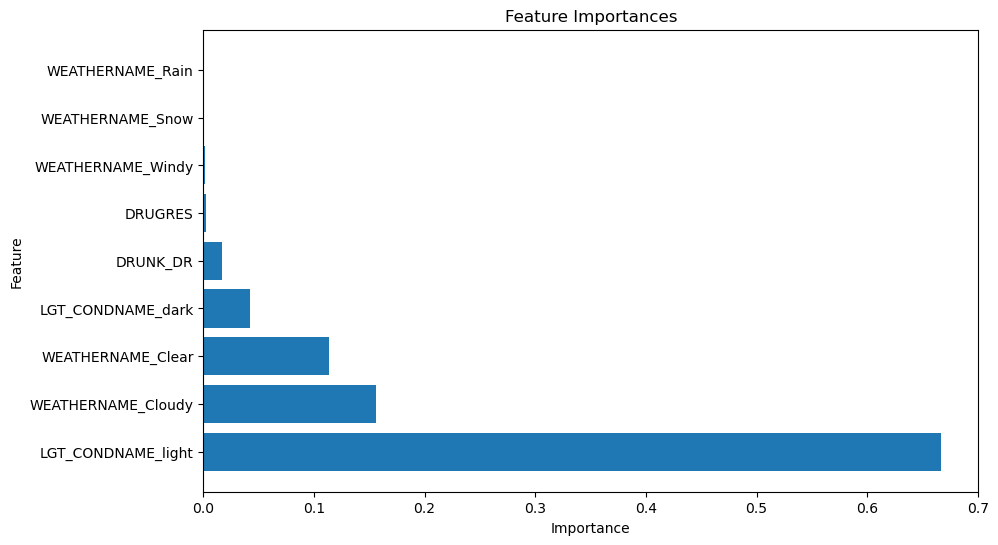

In [332]:
# 获取特征重要性
regressor = model.named_steps['regressor']
feature_importances = regressor.feature_importances_

# 获取预处理后的特征名
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist() + numerical_features

# 创建特征重要性数据框
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [334]:
# some example data
example_data = pd.DataFrame({
    'LGT_CONDNAME': ['light', 'dark', 'light', 'dark'],
    'WEATHERNAME': ['Rain', 'Rain', 'Clear', 'Cloudy'],
    'RUR_URBNAME': ['Rural', 'Rural', 'Urban', 'Rural'],
    'DRUNK_DR': [1, 1, 0, 0],
    'DRUGRES': [1, 1, 0, 0]
})

# precdict the example data with the trained model
example_predictions = model.predict(example_data)

print("Example Predictions:")
print(example_predictions.round(4))

Example Predictions:
[0.6438 0.6843 0.4408 0.5595]


In [338]:
import pandas as pd
import itertools


lgt_cond_values = ['light', 'dark']
weather_values = ['Clear', 'Rain']
rur_urb_values = ['Rural', 'Urban']
drunk_dr_values = [0, 1]
drugres_values = [0, 1]

# generate all possible combinations of the values
combinations = list(itertools.product(lgt_cond_values, weather_values, rur_urb_values, drunk_dr_values, drugres_values))

# create a DataFrame with the combinations
example_data = pd.DataFrame(combinations[:9], columns=['LGT_CONDNAME', 'WEATHERNAME', 'RUR_URBNAME', 'DRUNK_DR', 'DRUGRES'])
example_data = example_data.append({'LGT_CONDNAME': 'dark', 'WEATHERNAME': 'Clear', 'RUR_URBNAME': 'Rural', 'DRUNK_DR': 0, 'DRUGRES': 0}, ignore_index=True)

example_data_encoded = preprocessor.transform(example_data)


example_predictions = model.named_steps['regressor'].predict(example_data_encoded)

example_data['Prediction'] = example_predictions
print("Example Predictions:")
print(example_data[['LGT_CONDNAME', 'WEATHERNAME', 'RUR_URBNAME', 'DRUNK_DR', 'DRUGRES', 'Prediction']])

Example Predictions:
  LGT_CONDNAME WEATHERNAME RUR_URBNAME  DRUNK_DR  DRUGRES  Prediction
0        light       Clear       Rural         0        0    0.440774
1        light       Clear       Rural         0        1    0.584585
2        light       Clear       Rural         1        0    0.459711
3        light       Clear       Rural         1        1    0.627521
4        light       Clear       Urban         0        0    0.440774
5        light       Clear       Urban         0        1    0.584585
6        light       Clear       Urban         1        0    0.459711
7        light       Clear       Urban         1        1    0.627521
8        light        Rain       Rural         0        0    0.415281
9         dark       Clear       Rural         0        0    0.559453


/var/folders/t9/plt56vgx1nx_6xff98fhl2dc0000gn/T/ipykernel_10212/4257064823.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  example_data = example_data.append({'LGT_CONDNAME': 'dark', 'WEATHERNAME': 'Clear', 'RUR_URBNAME': 'Rural', 'DRUNK_DR': 0, 'DRUGRES': 0}, ignore_index=True)
